# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2024. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
# Imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tueplots import bundles

In [2]:
# Define constants
ROUNDING_DIGITS = 4
STARTING_DAY = 580
SAVE_EVERYTHING = True  # If you want to save the plots from this notebook or not
COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]
#Original Colors: ['#4e75b8', '#dc813b', '#a4a4a4', '#f6c042', '#29437c', '#97481d', '#7eab4a', '#616161', '#6b98d0', '#9b7425']
TREATEMENT_LIST = ['None', 'Rapamycin', 'HSCs', 'Gal-Nav', 'no_Rapamycin', 'no_HSCs', 'mTERT', 'no_Gal_Nav', 'no_mTERT', 'All']


USE_LATEX = False
FILE_SAVE_ENDING = '.pdf'    # Download it once as .jpg to make the comparison with the original data plots

We need data of single and multiple treatments. For that we used the data of the first study of ['Robust Mouse Rejuvenation' (RMR)](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1). Unfortunately we did not get access to their data set, but their evaluation plots are available [online](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1/study-updates/november-5th-2023-cem49). So lets have a look at it.

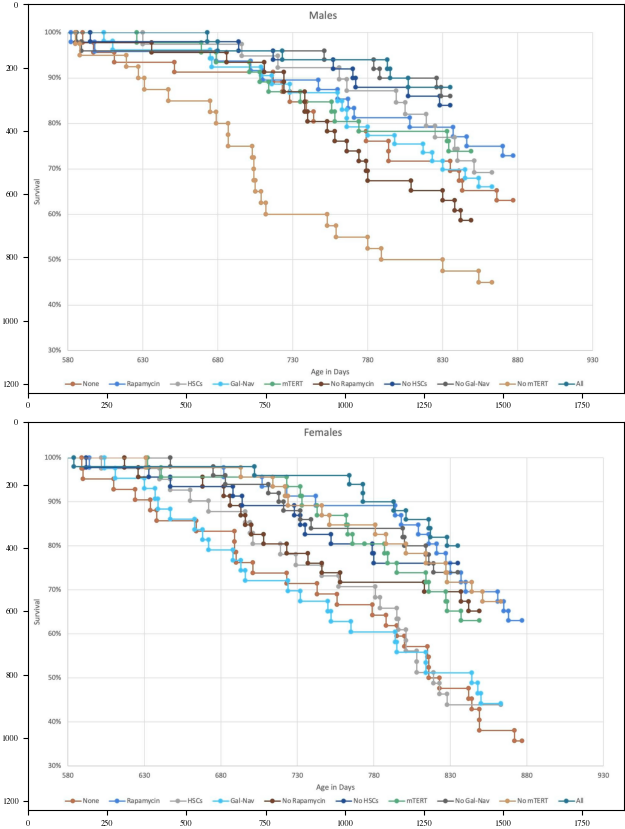

In [3]:
raw_plot_image_male = cv2.imread('../dat/img/23_12_RMR_Males.jpg')
raw_plot_image_female = cv2.imread('../dat/img/23_12_RMR_Females.jpg')
plt.rcParams.update(bundles.icml2022(column='full', nrows=2, ncols=1, usetex=USE_LATEX))
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(raw_plot_image_male)
ax2.imshow(raw_plot_image_female)

We are lucky that there are not that many data points in each plot. So that is why we took the fastest option for us and collected the data points manually. For that we used [plotdigitilizer](https://plotdigitizer.com/).

In [4]:
def loadCSV(path):
    df = pd.read_csv(
        path,
        skiprows=0,
        sep=',',
        engine='python',
        decimal='.',
        dtype={'x': 'float64', 'y': 'float64'}
        )
    return df

female_df = loadCSV('../dat/RMR_data/female_None.csv')

female_df

,x,y
0,580.000000,1.000000
1,588.805073,0.977074
2,588.805073,1.001769
3,589.481503,0.952955
4,589.481503,0.977074
5,609.705129,0.953918
6,609.806652,0.931535
7,624.288914,0.929044
8,624.379169,0.906153
9,633.642365,0.882519


First you can see that each data point provides a lot of floating point numbers. That comes from the manual elicitation of the data points.
 
We decided to round the points to **four digits** in our analysis for simplicity. Furthermore, we added the starting point **(580, 1)** by hand. We did this because the study started their interventions with the mice after **18 months**. (See [RMR](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1))

In [5]:
def roundNumbers(df):
    df = df.apply(lambda x:round(x, ROUNDING_DIGITS))
    return df

In [6]:
def addColumn(data_frame, col_name, col_value):
    data_frame[col_name] = col_value

In [7]:
# Round the numbers of the x and y columns
female_df = roundNumbers(female_df)

# Add the columns for the first group
addColumn(female_df, 'sex', 'female')
addColumn(female_df, 'category', 'None')

female_df

,x,y,sex,category
0,580.0000,1.0000,female,None
1,588.8051,0.9771,female,None
2,588.8051,1.0018,female,None
3,589.4815,0.9530,female,None
4,589.4815,0.9771,female,None
5,609.7051,0.9539,female,None
6,609.8067,0.9315,female,None
7,624.2889,0.9290,female,None
8,624.3792,0.9062,female,None
9,633.6424,0.8825,female,None


## Sanity Check
We want to see if our data points are representing the data of the figures. We will check this with a plot.

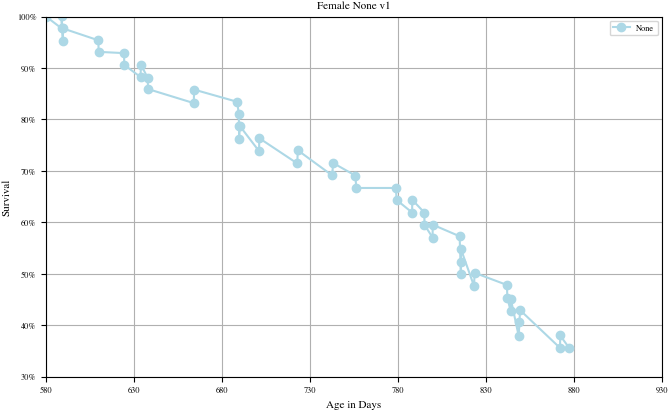

In [8]:
def plotTimeline(df, title, path, col_state='full', nrow=1, ncols=1, uselatex=False):
    
    plt.rcParams.update(bundles.icml2022(column=col_state, nrows=nrow, ncols=ncols, usetex=uselatex))
    
    fig, ax = plt.subplots(nrow, ncols)
    
    df_category_group = df.groupby('category', sort=False)
    
    for i, (name, group) in enumerate(df_category_group):
        x_data = group['x']
        y_data = group['y']
        ax.plot(x_data, y_data, color=COLOR_MAP[i], marker='o', linestyle='-', label=name)
    
    ax.set_xlim(580, 930)
    ax.set_ylim(0.3, 1)
    ax.set_xticks(np.arange(580, 931, 50))
    ax.set_yticks(np.arange(0.3, 1.01, 0.1))
    ax.grid(True)
    ax.set_xlabel('Age in Days')
    ax.set_ylabel('Survival')
    ax.set_title(title)
    ax.legend(loc='best')
    
    def to_percent(y, position):
        return f'{100 * y:.0f}%'
    
    # Create a formatter and apply it to the y-axis
    formatter = FuncFormatter(to_percent)
    ax.yaxis.set_major_formatter(formatter)
    
    if SAVE_EVERYTHING:
        fig.savefig(path)
        
plotTimeline(female_df, 'Female None v1', '../dat/img/2401_sanity_check_female_none_v1' + FILE_SAVE_ENDING)

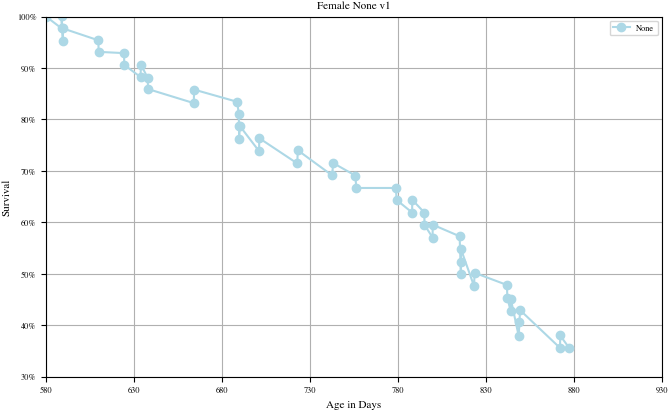

In [9]:
plotTimeline(female_df, 'Female None v1', '../dat/img/2401_sanity_check_female_none_v1' + FILE_SAVE_ENDING)

Now we have a problem. First, the data points are not in the right order. Secondly you can see some errors have occured during the data collection. Some data points in the future have a higher survival rate then in the past. This does not make sense, so we have to also clip the values.

In [10]:
def preprocess_data(df):
    # Function to adjust x values
    def adjust_x(row, prev_row):
        if prev_row is not None:
            if abs(row['x'] - prev_row['x']) <= 2:  # If the distance of the x-values are less than 2
                row['x'] = min(row['x'], prev_row['x'])
        return row
    
    # Function to adjust y values
    def adjust_y(row, prev_row):
        if prev_row is not None:
            if row['y'] > prev_row['y']:    # If the current row has a bigger y value than the previous, set the value to the previous
                row['y'] = prev_row['y']
            elif row['x'] > prev_row['x']:
                row['y'] = prev_row['y']
        return row
    
    # Adjusting x values
    prev_row = None
    for index, row in df.iterrows():
        df.loc[index] = adjust_x(row, prev_row)
        prev_row = row
        
    df = df.sort_values(by=['x', 'y'], ascending=[True, False])

    # Adjusting y values
    prev_row = None
    for index, row in df.iterrows():
        df.loc[index] = adjust_y(row, prev_row)
        prev_row = row
        
    # Delete duplicates
    df = df.drop_duplicates(subset=['x', 'y'])
    
    return df

In [11]:
female_df = preprocess_data(female_df)

female_df

,x,y,sex,category
0,580.0000,1.0000,female,None
2,588.8051,1.0000,female,None
1,588.8051,0.9771,female,None
3,588.8051,0.9530,female,None
5,609.7051,0.9530,female,None
6,609.7051,0.9315,female,None
7,624.2889,0.9315,female,None
8,624.2889,0.9062,female,None
10,633.6424,0.9062,female,None
9,633.6424,0.8825,female,None


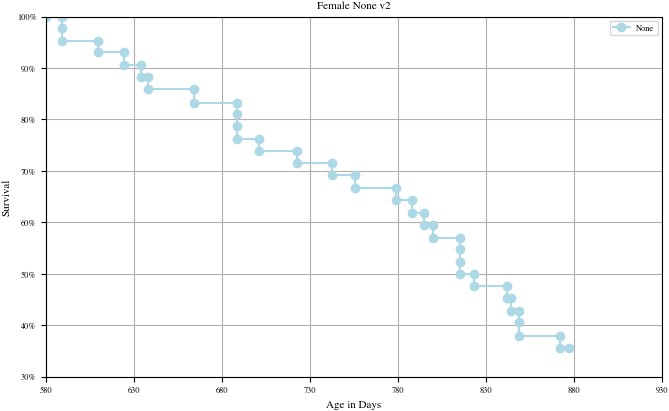

In [12]:
plotTimeline(female_df, 'Female None v2', '../dat/img/2401_sanity_check_female_none_v2' + FILE_SAVE_ENDING)

This looks better. Now we will collect all the data points and see how well we fit the original data with our approximations.

In [13]:
def addTableToDataFrame(df, path, sex, category):
    tabledf = loadCSV(path)
    tabledf = roundNumbers(tabledf)
    addColumn(tabledf, 'sex', sex)
    addColumn(tabledf, 'category', category)
    tabledf = preprocess_data(tabledf)
    df = pd.concat([df, tabledf], ignore_index=True)
    return df

# Add the other groups to this data frame
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_Rapamycin.csv', 'female', 'Rapamycin')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_HSCs.csv', 'female', 'HSCs')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_Gal-Nav.csv', 'female', 'Gal-Nav')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_no_Rapamycin.csv', 'female', 'no_Rapamycin')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_no_HSCs.csv', 'female', 'no_HSCs')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_mTERT.csv', 'female', 'mTERT')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_no_Gal-Nav.csv', 'female', 'no_Gal_Nav')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_no_mTERT.csv', 'female', 'no_mTERT')
female_df = addTableToDataFrame(female_df, '../dat/RMR_data/female_All.csv', 'female', 'All')

female_df

,x,y,sex,category
0,580.0000,1.0000,female,None
1,588.8051,1.0000,female,None
2,588.8051,0.9771,female,None
3,588.8051,0.9530,female,None
4,609.7051,0.9530,female,None
...,...,...,...,...
348,816.1809,0.8413,female,All
349,816.1809,0.8193,female,All
350,827.7304,0.8193,female,All
351,827.7304,0.7998,female,All


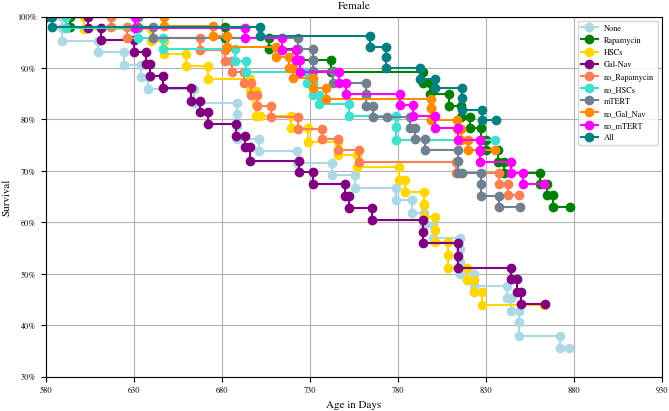

In [14]:
plotTimeline(female_df, 'Female', '../dat/img/2401_sanity_check_female_final' + FILE_SAVE_ENDING)

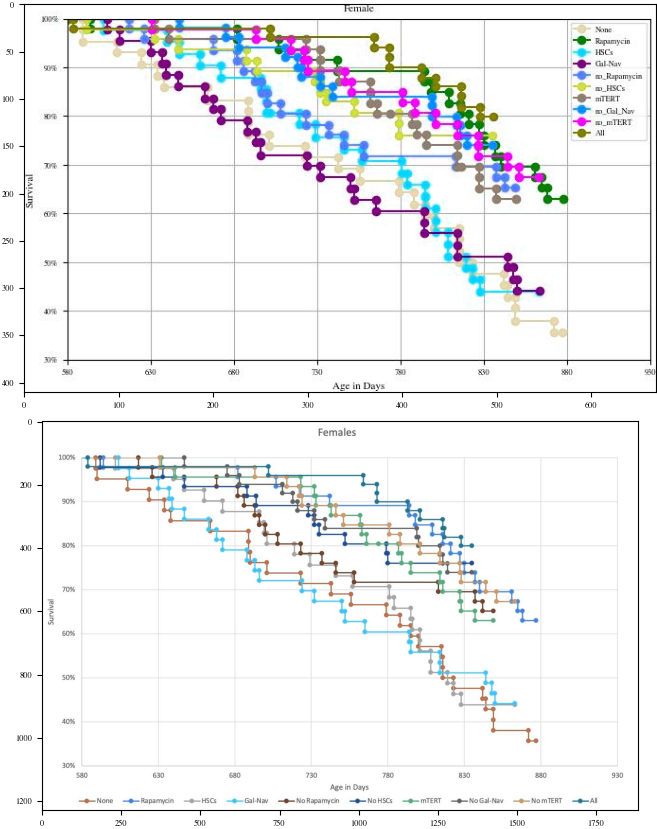

In [15]:
plot_female = cv2.imread('../dat/img/2401_sanity_check_female_final.jpg')
plt.rcParams.update(bundles.icml2022(column='full', nrows=2, ncols=1, usetex=USE_LATEX))
_, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(plot_female)
ax2.imshow(raw_plot_image_female)

That looks good. Let us do it for the male population as well.

In [16]:
def initializeDataFrame(path, sex, category):
    df = loadCSV(path)
    df = roundNumbers(df)
    addColumn(df, 'sex', sex)
    addColumn(df, 'category', category)
    df = preprocess_data(df)
    return df

male_df = initializeDataFrame('../dat/RMR_data/male_None.csv', 'male', 'None')

# Add the other groups to this data frame
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_Rapamycin.csv', 'male', 'Rapamycin')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_HSCs.csv', 'male', 'HSCs')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_Gal-Nav.csv', 'male', 'Gal-Nav')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_no_Rapamycin.csv', 'male', 'no_Rapamycin')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_no_HSCs.csv', 'male', 'no_HSCs')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_mTERT.csv', 'male', 'mTERT')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_no_Gal-Nav.csv', 'male', 'no_Gal_Nav')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_no_mTERT.csv', 'male', 'no_mTERT')
male_df = addTableToDataFrame(male_df, '../dat/RMR_data/male_All.csv', 'male', 'All')

male_df

,x,y,sex,category
0,580.0000,1.0000,male,None
1,589.9457,1.0000,male,None
2,589.9457,0.9780,male,None
3,596.8188,0.9780,male,None
4,596.8188,0.9557,male,None
...,...,...,...,...
278,792.7592,0.9194,male,All
279,794.8739,0.9194,male,All
280,806.9562,0.9194,male,All
281,806.9562,0.8798,male,All


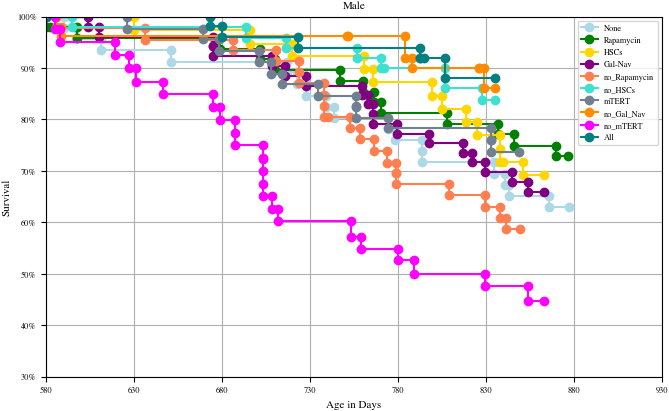

In [17]:
plotTimeline(male_df, 'Male', '../dat/img/2401_sanity_check_male_final' + FILE_SAVE_ENDING)

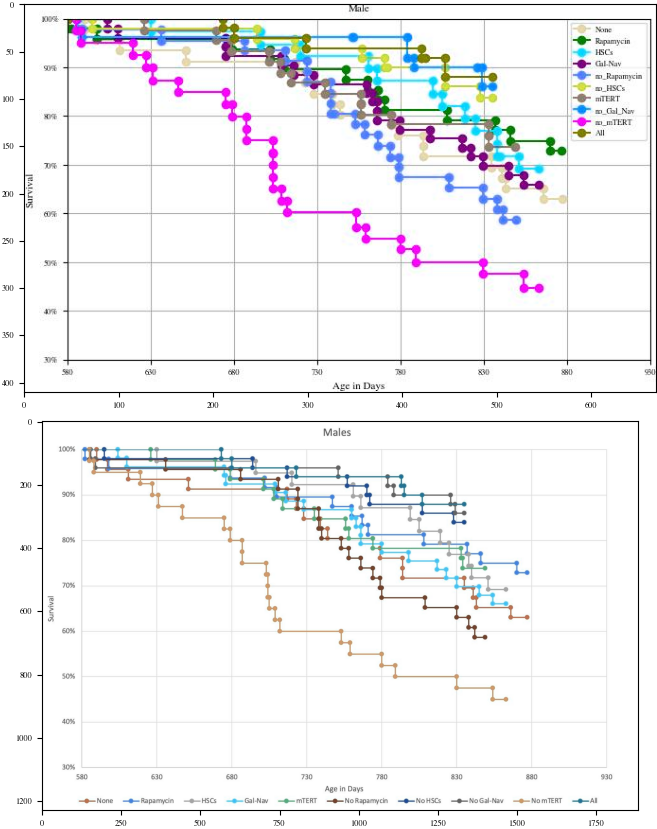

In [18]:
plot_male = cv2.imread('../dat/img/2401_sanity_check_male_final.jpg')
plt.rcParams.update(bundles.icml2022(column='full', nrows=2, ncols=1, usetex=USE_LATEX))
_, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(plot_male)
ax2.imshow(raw_plot_image_male)

Finally, we save the data frames as csv files to use them for our further data analysis.

In [19]:
if SAVE_EVERYTHING:
    female_df.to_csv('../dat/final_datasets/female_final.csv', index=False)
    male_df.to_csv('../dat/final_datasets/male_final.csv', index=False)